In [1]:
import os
import math
import re
import boto3
import itertools
import json
import inspect


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sagemaker.session import Session
from joblib import dump, load

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, classification_report

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold

In [73]:
a.sample(frac=1).to_csv('asset_lineitem_training_testing.csv', index=False)
b.sample(frac=1).to_csv('liable_lineitem_training_testing.csv', index=False)

## Helper Functions & Classes

In [3]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Interact with System Environment

In [4]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

## Classification Model Training 
**We implement a classification model, with a hashing vectorizer to convert our string data into numerical measures**

In [5]:
def cls_sec(X, y, vectorizer, classification, parameters:dict, cvSplits:int=5, rng:int=1) -> tuple:
    """
    Performs (cross-validated) classification on text-based data
    ------------------------------------------------------------------------------------------
    Input:
        :param: X (type pandas.DataFrame) 
            A Nx1 dimensional DataFrame that stores the original balance-sheet "lineitems" 
        :param: y (type pandas.DataFrame) 
            A Nx1 dimensional DataFrame that stores the classification of each balance-sheet 
            "lineitem" provided under the X parameter 
        :param: vectorizer (type sklearn.text_vectorizer model) 
            A sklearn text feature extraction model (e.g. HashingVectorizer)
        :param: classification (type sklearn.classification model) 
            A sklearn classification model (e.g. LinearSVC)
        :param: parameters (type dict) 
            A dictionary of parameters for the sklearn.classification model to try
        :param: cvSplits (type int) 
            A positive integer indicating the number of cross-validation splits to perform
            on a given dataset. Note that depending on the size of the dataset provided,
            a smaller number of cvSplits is advised. We set default splits to 5. 
        :param: rng (type int) 
            The seed for the random number generator, we default to 1. 
    Return:
        :return: (type tuple)
            :return: clf
                Trained classification mode, post cross-validation
            :return: predDF
                A DataFrame storing the original lineitems, their
                manual classifications, model predictions and the
                accompanying prediction probabilities
            :return: y_test
                The reponse test set used post-training
            :return: y_pred
                The response predictions from the model
            :return: cv_score
                The cross-validated score for returned (best) model 
    """
    
    # cross-validating engine used for CV score
    cv = KFold(n_splits=cvSplits, shuffle=True, random_state=rng)
    
    # vectorizes the text via HashingVector to be used in classification implementation 
    xVector = vectorizer.fit_transform(X.values.flatten())
    yVector = y.values.ravel()
    
    # compute the cross-validation for sample using base classification model
    cv_score = cross_val_score(classification, xVector, yVector, cv=cv, scoring='f1_macro', verbose=0)
    
    # -------------------------------------------------------------------------------------------
    # Report back preliminary measures of default-model accuracy
    # -------------------------------------------------------------------------------------------
    print('Cross-validation measures using {} splits for default {} classifier'.format(cvSplits, 
                                                                                       type(classification).__name__))
    print(cv_score)
    print('\nDefault estimator\n', classification)
    print('Average cross-validation score using base classifier: {s}%\n'.format(s=round(np.average(cv_score) * 100, 4)))
    
    # split dependent and independent variables into training and testing windows (random split)
    X_train, X_test, y_train, y_test = train_test_split(xVector, yVector, test_size=0.20, shuffle=True, 
                                                        random_state=rng)
    
    # retreive test names for X (dependent) values, retain random state to match values for forecasts
    _, test_names, _, _ = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=rng)
    
    # exhaustive search over specified parameter values for an estimator optimized by cross-validation
    clf = GridSearchCV(estimator=classification, param_grid=parameters, n_jobs=1, cv=cv, verbose=1)
    
    # fit the classification model
    clf.fit(X_train, y_train)
    
    # predict target classes based on classification model
    y_pred = clf.predict(X_test)
    
    # compute the corresponding probabilites for each prediction
    proba = clf.predict_proba(xVector)
    
    # -------------------------------------------------------------------------------------------
    # Report back important measures of model accuracy
    # -------------------------------------------------------------------------------------------
    print('Best GridSearchCV estimator\n', clf.best_estimator_)
    print('Best GridSearchCV score: {}%'.format(round(clf.best_score_ * 100, 4)))
    
    score = round(precision_score(y_test, y_pred, average='micro') * 100, 4)
    print("\nPercision score from prediction using a micro average: {s}%".format(s=score))
    
    print('1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)')
    print('1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)')
    print('\n', classification_report(y_test, y_pred))
    
    # -------------------------------------------------------------------------------------------
    # construct a dataframe to keep track of all predictions for the dataset 
    # -------------------------------------------------------------------------------------------
    c1 = pd.DataFrame(X[['LineItems']].values, 
                      columns=['Raw Lineitems'])
    c2 = pd.DataFrame(y[['classification']].values, 
                      columns=['Manual Classification'])
    c3 = pd.DataFrame(clf.predict(xVector), 
                      columns=['Model Predictions'])
    c4 = pd.DataFrame(proba, columns=clf.classes_)           # each column stores the prediction probability

    predDF = c1.join(c2).join(c3).join(c4)
    
    # reports back the maximum probability per row (use for each flag)
    predDF['Max Probability'] = predDF[predDF.columns[3:]].max(axis=1)
    # -------------------------------------------------------------------------------------------
    
    return clf, predDF, y_test, y_pred, cv_score

In [6]:
def cMatrix(testcase:np.ndarray, prediction:np.ndarray):
    """
    Computes a confusion matrix from classification predictions, outputing heatmap
    """
    
    # each row shows the count of each corresponding label column wise, should have the columns the most populated
    labelNames = np.unique(np.concatenate((np.unique(testcase), np.unique(prediction))))
    cmat = pd.DataFrame(confusion_matrix(testcase, prediction, normalize=None), 
                        columns=labelNames, index=labelNames)
    scaled_df = (cmat - cmat.min(axis=0)) / (cmat.max(axis=0) - cmat.min(axis=0))
    
    plt.figure(figsize=(15, 9))
    plt.title('Confusion Matrix (test-sample)', fontsize=14)
    sns.heatmap(scaled_df, annot=cmat, linewidths=.5, cmap="RdYlGn")
    plt.ylabel('Expected LineItems', fontsize=14)
    plt.xlabel('Predicted LineItems', fontsize=14)
    plt.show()

In [7]:
# read in asset and liability line items to be parsed
assetML = pd.read_csv('asset_lineitem_training_testing.csv')
liabilityML = pd.read_csv('liability_lineitem_training_testing.csv')

In [8]:
# break subset of line items and classification, for classification algorithm 
X1 = assetML[['LineItems']]
y1 = assetML[['classification']]

X2 = liabilityML[['LineItems']]
y2 = liabilityML[['classification']]

**Asset-line items classification model**

In [9]:
# return: Classification Model, Prediciton Mapping, Y-Perdictions, cross-validated score
asset_mdl, asset_pred_df, asset_tests, asset_preds, asset_cv = cls_sec(X=X1, y=y1, 
                                    vectorizer=HashingVectorizer(strip_accents='unicode', lowercase=True, 
                                                                 analyzer='word', n_features=1000,  
                                                                 norm='l2'), 
                                    classification=LogisticRegression(), 
                                    parameters={'penalty':['l2'], 'dual': [False], 'C': [1, 5, 10],
                                                'fit_intercept': [True], 'intercept_scaling': [1, 5, 10],
                                                'class_weight': ['balanced', None], 'random_state': [1], 
                                                'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                                                'max_iter': [1000], 'multi_class': ['multinomial']}, 
                                    cvSplits=5, rng=1)

Cross-validation measures using 5 splits for default LogisticRegression classifier
[0.75212617 0.74903798 0.80507618 0.81195904 0.74487953]

Default estimator
 LogisticRegression()
Average cross-validation score using base classifier: 77.2616%

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

Best GridSearchCV estimator
 LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=1,
                   solver='newton-cg')
Best GridSearchCV score: 93.0594%

Percision score from prediction using a micro average: 94.1606%
1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)
1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)

                                                          precision    recall  f1-score   support

                                     Account receivable       0.71      1.00      0.83         5
              Accumulated depreciation and amortization       1.00      0.94      0.97        16
                              Cash and cash equivalents       0.79      1.00      0.88        15
Cash and securities segregated for benefit of customers       1.00      1.00      1.00         3
           

In [10]:
asset_pred_df.to_csv('asset_ml_proba.csv', index=False)

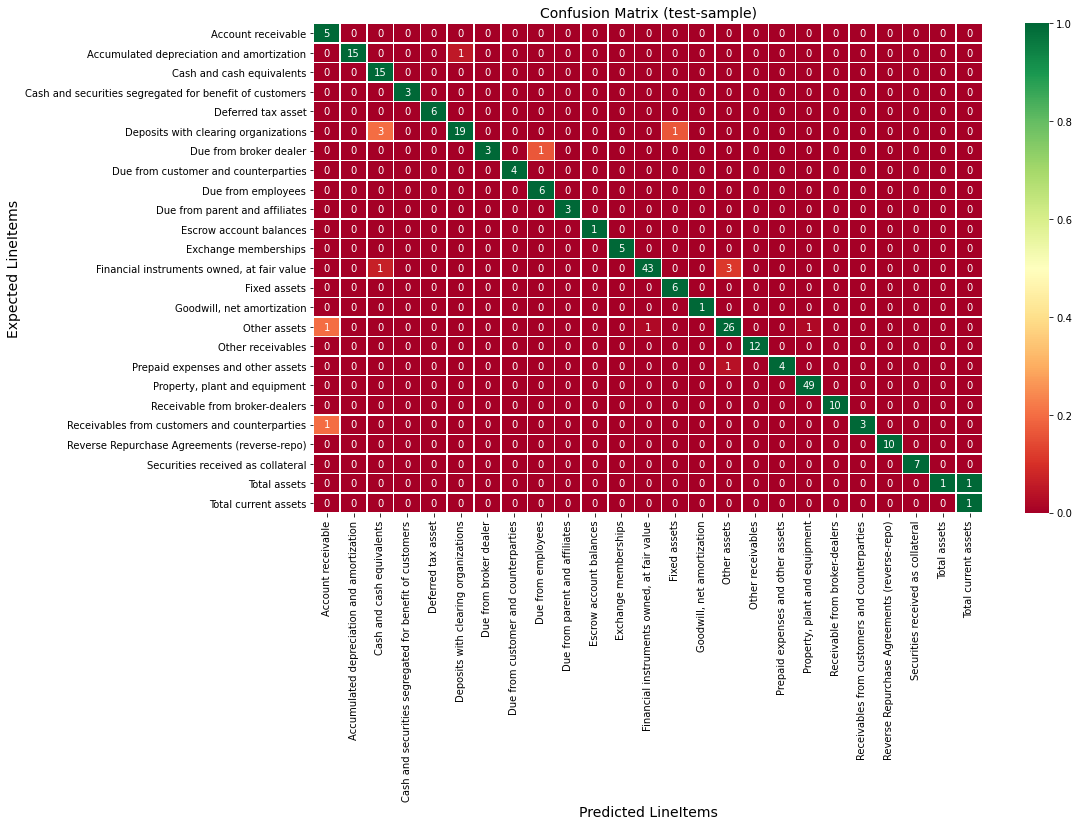

In [11]:
cMatrix(asset_tests, asset_preds)

In [46]:
# will be deleted in future instances

df = pd.read_csv('unstructured_assets.csv')
X = df.columns[5:]
str_mdl = HashingVectorizer(strip_accents='unicode', lowercase=True, 
                            analyzer='word', n_features=1000, norm='l2')
preds = asset_mdl.predict(str_mdl.fit_transform(X))
proba = asset_mdl.predict_proba(str_mdl.fit_transform(X))

a = pd.DataFrame(X, columns=['Lineitems'])
b = pd.DataFrame(preds, columns=['Prediction'])
c = pd.DataFrame(proba, columns=asset_mdl.classes_)

a.join(b).join(c).to_csv('current_asset_ml.csv')

**Liability & Equity line items classification model**

In [12]:
# return: Classification Model, Prediciton Mapping, Y-Perdictions, cross-validated score
liablity_mdl, liablity_pred_df, liablity_tests, liablity_preds, liablity_cv = cls_sec(X=X2, y=y2, 
                                    vectorizer=HashingVectorizer(strip_accents='unicode', lowercase=True, 
                                                                 analyzer='word', n_features=1000,  
                                                                 norm='l2'), 
                                    classification=LogisticRegression(), 
                                    parameters={'penalty':['l2'], 'dual': [False], 'C': [1, 5, 10],
                                                'fit_intercept': [True], 'intercept_scaling': [1, 5, 10],
                                                'class_weight': ['balanced', None], 'random_state': [1], 
                                                'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                                                'max_iter': [1000], 'multi_class': ['multinomial']}, 
                                    cvSplits=5, rng=1)

Cross-validation measures using 5 splits for default LogisticRegression classifier
[0.66471243 0.69705243 0.68935452 0.67008632 0.72039771]

Default estimator
 LogisticRegression()
Average cross-validation score using base classifier: 68.8321%

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

Best GridSearchCV estimator
 LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=1,
                   solver='newton-cg')
Best GridSearchCV score: 91.4231%

Percision score from prediction using a micro average: 91.3462%
1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)
1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)

                                               precision    recall  f1-score   support

                            Accounts payable       0.89      0.94      0.92        18
                         Accrued liabilities       0.90      1.00      0.95         9
                  Additional Paid-in capital       1.00      0.75      0.86         4
                     Common stock, par value       1.00      0.91      0.95        32
                         Current liabilities       0.86      1.00 

In [13]:
liablity_pred_df.to_csv('liable_ml_proba.csv', index=False)

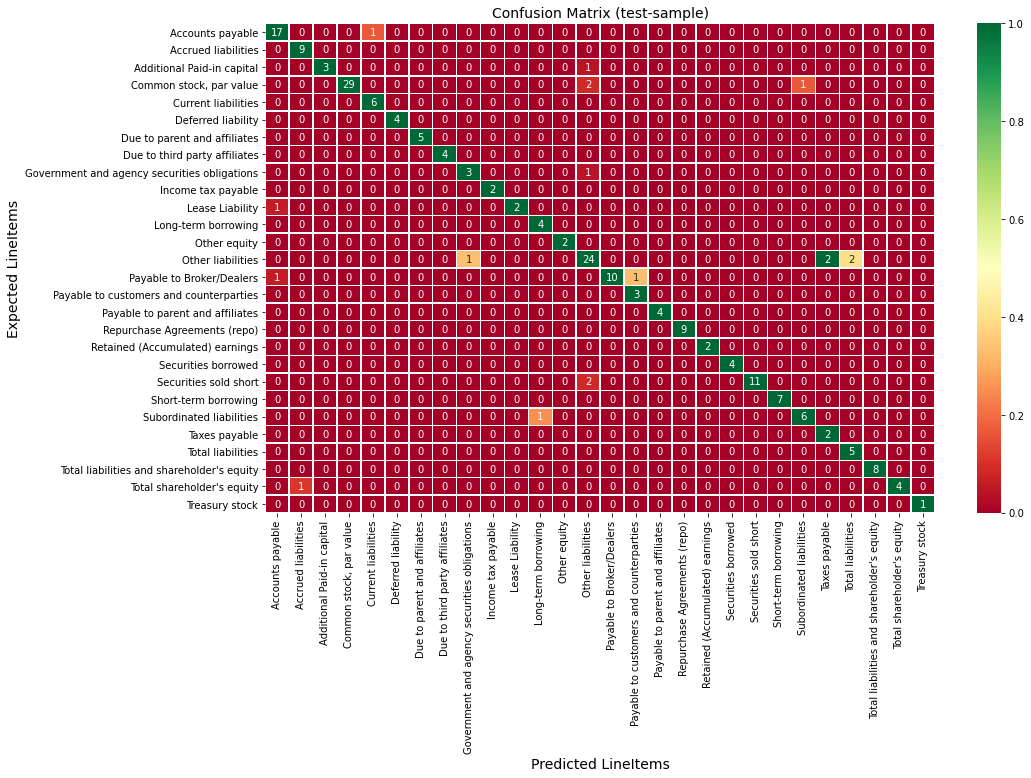

In [14]:
cMatrix(liablity_tests, liablity_preds)

In [47]:
# will be deleted in future instances

df = pd.read_csv('unstructured_liable.csv')
X = df.columns[5:]
str_mdl = HashingVectorizer(strip_accents='unicode', lowercase=True, 
                            analyzer='word', n_features=1000, norm='l2')
preds = liablity_mdl.predict(str_mdl.fit_transform(X))
proba = liablity_mdl.predict_proba(str_mdl.fit_transform(X))

a = pd.DataFrame(X, columns=['Lineitems'])
b = pd.DataFrame(preds, columns=['Prediction'])
c = pd.DataFrame(proba, columns=liablity_mdl.classes_)

a.join(b).join(c).to_csv('current_liable_ml.csv')

**Saving trained model to joblib for export, binary for model strictly**

In [15]:
# for storing model persistence https://scikit-learn.org/stable/modules/model_persistence.html
# dump asset & liability model classifiers () for future use
dump(asset_mdl, 'trained_models/asset_log_reg_mdl_v1.joblib') 

['asset_log_reg_mdl_v1.joblib']

In [16]:
dump(liablity_mdl, 'trained_models/liability_log_reg_mdl_v1.joblib') 

['liability_log_reg_mdl_v1.joblib']